# 分割 matched-outside-but-dominated

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

模式匹配了 `nn.conv2d/add/multiply` 流程。尽管 `add` 的输出被 `sigmoid` 消耗了，但 `sigmoid` 本身受到 `multiply` 的控制。

构建计算图：

In [3]:
in_mod = tvm.relay.parse(
    """
    #[version = "0.0.5"]
    def @main(%data: Tensor[(16, 16, 32, 32), float16], %weight: Tensor[(32, 16, 3, 3), float16], %bias: Tensor[(32), float32]) -> Tensor[(16, 32, 32, 32), float32] {
        %0 = layout_transform(%data, src_layout="NCHW", dst_layout="NHWC");
        %1 = layout_transform(%weight, src_layout="OIHW", dst_layout="OHWI");
        %2 = expand_dims(%bias, axis=1, num_newaxis=2);
        %3 = expand_dims(%2, axis=0);
        %4 = nn.conv2d(%0, %1, padding=[1, 1, 1, 1], channels=32, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="OHWI", out_dtype="float32");
        %5 = layout_transform(%3, src_layout="NCHW", dst_layout="NHWC");
        %6 = add(%4, %5);
        %7 = sigmoid(%6);
        %8 = multiply(%6, %7);
        layout_transform(%8, src_layout="NHWC", dst_layout="NCHW")
    }
    """
)

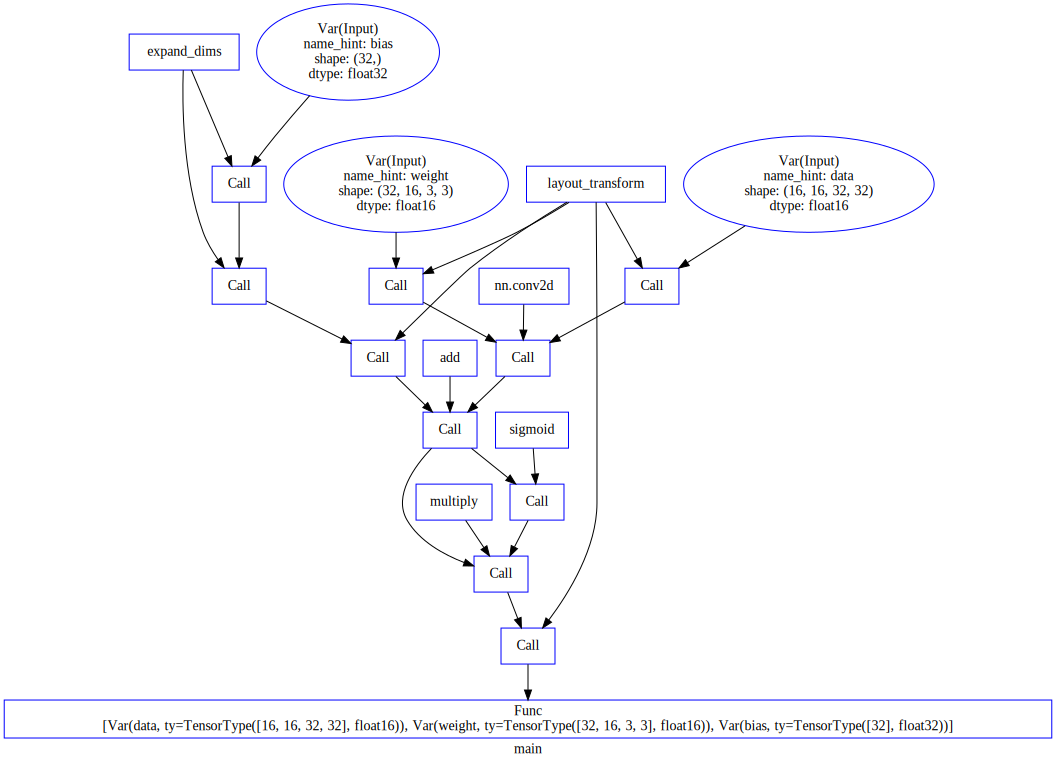

In [6]:
viz_expr(in_mod["main"])

In [5]:
print(in_mod)

def @main(%data: Tensor[(16, 16, 32, 32), float16] /* ty=Tensor[(16, 16, 32, 32), float16] span=from_string:4:31 */, %weight: Tensor[(32, 16, 3, 3), float16] /* ty=Tensor[(32, 16, 3, 3), float16] span=from_string:5:31 */, %bias: Tensor[(32), float32] /* ty=Tensor[(32), float32] span=from_string:6:26 */) -> Tensor[(16, 32, 32, 32), float32] {
  %0 = layout_transform(%data, src_layout="NCHW", dst_layout="NHWC") /* ty=Tensor[(16, 32, 32, 16), float16] span=from_string:8:24 */;
  %1 = layout_transform(%weight, src_layout="OIHW", dst_layout="OHWI") /* ty=Tensor[(32, 3, 3, 16), float16] span=from_string:8:28 */;
  %2 = expand_dims(%bias, axis=1, num_newaxis=2) /* ty=Tensor[(32, 1, 1), float32] span=from_string:7:26 */;
  %3 = expand_dims(%2, axis=0) /* ty=Tensor[(1, 32, 1, 1), float32] span=from_string:9:31 */;
  %4 = nn.conv2d(%0, %1, padding=[1, 1, 1, 1], channels=32, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="OHWI", out_dtype="float32") /* ty=Tensor[(16, 32, 32, 32), float32] 

构建模式：

In [7]:
pattern = is_op("multiply")(
    is_op("add")(is_op("nn.conv2d")(wildcard(), wildcard()), wildcard()), wildcard()
)

分割计算图：

In [8]:
partitioned = pattern.partition(in_mod["main"])

In [9]:
print(tvm.IRModule.from_expr(partitioned))

def @main(%data: Tensor[(16, 16, 32, 32), float16] /* ty=Tensor[(16, 16, 32, 32), float16] span=from_string:4:31 */, %weight: Tensor[(32, 16, 3, 3), float16] /* ty=Tensor[(32, 16, 3, 3), float16] span=from_string:5:31 */, %bias: Tensor[(32), float32] /* ty=Tensor[(32), float32] span=from_string:6:26 */) -> Tensor[(16, 32, 32, 32), float32] {
  %2 = expand_dims(%bias, axis=1, num_newaxis=2) /* ty=Tensor[(32, 1, 1), float32] span=from_string:7:26 */;
  %3 = expand_dims(%2, axis=0) /* ty=Tensor[(1, 32, 1, 1), float32] span=from_string:9:31 */;
  %4 = layout_transform(%data, src_layout="NCHW", dst_layout="NHWC") /* ty=Tensor[(16, 32, 32, 16), float16] span=from_string:8:24 */;
  %5 = layout_transform(%weight, src_layout="OIHW", dst_layout="OHWI") /* ty=Tensor[(32, 3, 3, 16), float16] span=from_string:8:28 */;
  %6 = nn.conv2d(%4, %5, padding=[1, 1, 1, 1], channels=32, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="OHWI", out_dtype="float32") /* ty=Tensor[(16, 32, 32, 32), float32] 